A. Calculating exponentially weighted covariance matrices...

Sample of EWCOV matrix with λ = 0.94:
           SPY      AAPL      NVDA      MSFT      AMZN
SPY   0.000080  0.000058  0.000115  0.000086  0.000119
AAPL  0.000058  0.000139 -0.000002  0.000086  0.000083
NVDA  0.000115 -0.000002  0.000572  0.000107  0.000180
MSFT  0.000086  0.000086  0.000107  0.000151  0.000172
AMZN  0.000119  0.000083  0.000180  0.000172  0.000292

B. Analyzing eigenvalue decay for different λ values...

C. Analyzing effects of λ on covariance structure...

λ = 0.10:
Variance explained by top 1 component: 0.9589
Variance explained by top 3 components: 0.9999
Variance explained by top 5 components: 1.0000

λ = 0.30:
Variance explained by top 1 component: 0.8741
Variance explained by top 3 components: 0.9969
Variance explained by top 5 components: 0.9994

λ = 0.50:
Variance explained by top 1 component: 0.7902
Variance explained by top 3 components: 0.9734
Variance explained by top 5 components: 0.9882

λ = 0

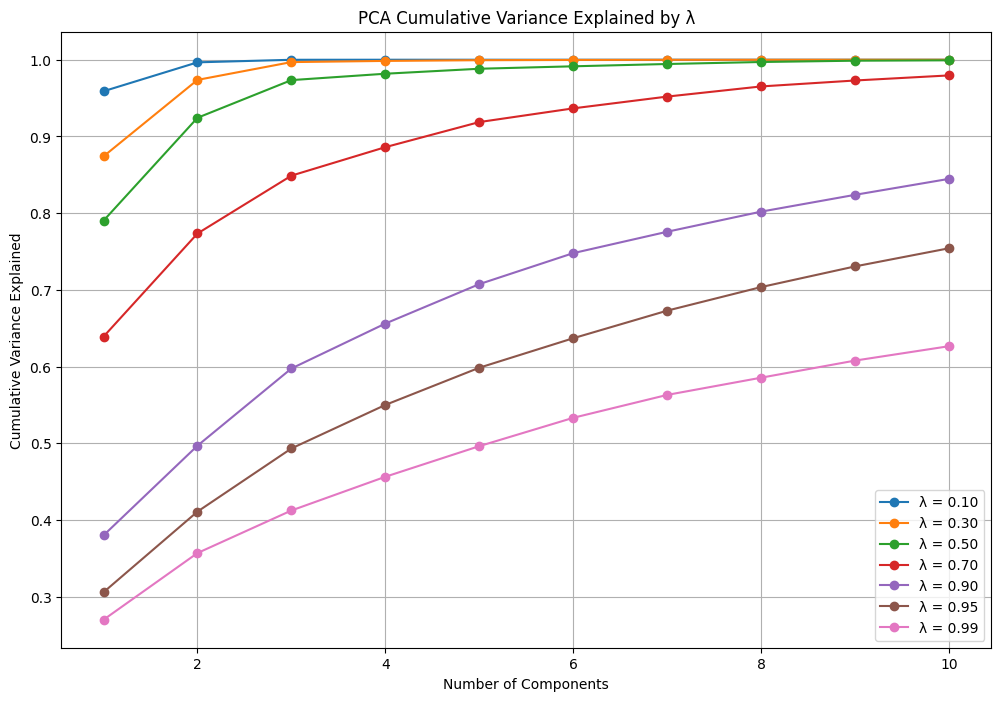

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt

def calculate_ewcov(returns, lambda_):
    """
    Calculate exponentially weighted covariance matrix
    
    Parameters:
    returns: DataFrame of returns
    lambda_: decay factor (0 < λ < 1)
    """
    # Remove date column if exists
    if 'Date' in returns.columns:
        returns = returns.drop('Date', axis=1)
    
    # Convert to numpy array for calculations
    X = returns.values
    n, p = X.shape
    
    # Calculate weights
    weights = np.array([(1 - lambda_) * lambda_**i for i in range(n-1, -1, -1)])
    weights = weights / weights.sum()
    
    # Calculate weighted mean
    weighted_mean = np.average(X, axis=0, weights=weights)
    
    # Center the data
    X_centered = X - weighted_mean
    
    # Calculate weighted covariance
    cov = np.zeros((p, p))
    for i in range(n):
        cov += weights[i] * np.outer(X_centered[i], X_centered[i])
    
    return cov

def analyze_eigenvalue_decay(returns, lambdas):
    """
    Analyze eigenvalue decay for different lambda values
    
    Parameters:
    returns: DataFrame of returns
    lambdas: list of lambda values to test
    """
    n_assets = len(returns.columns) - 1  # subtract Date column if exists
    results = []
    
    for lambda_ in lambdas:
        # Calculate covariance matrix
        cov = calculate_ewcov(returns, lambda_)
        
        # Calculate eigenvalues
        eigenvals = linalg.eigvalsh(cov)[::-1]  # sort in descending order
        
        # Calculate cumulative explained variance ratio
        total_var = eigenvals.sum()
        cum_var_ratio = np.cumsum(eigenvals) / total_var
        
        results.append({
            'lambda': lambda_,
            'eigenvals': eigenvals,
            'cum_var_ratio': cum_var_ratio
        })
    
    return results

def plot_cumulative_variance(results, num_components=10):
    """
    Plot cumulative variance explained for different lambda values
    """
    plt.figure(figsize=(12, 8))
    
    for result in results:
        lambda_ = result['lambda']
        cum_var = result['cum_var_ratio'][:num_components]
        plt.plot(range(1, len(cum_var) + 1), cum_var, 
                marker='o', label=f'λ = {lambda_:.2f}')
    
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('PCA Cumulative Variance Explained by λ')
    plt.legend()
    plt.grid(True)
    return plt.gcf()

def analyze_data(file_path='DailyReturn.csv'):
    """
    Main analysis function
    """
    # Read data
    df = pd.read_csv(file_path)
    
    # A. Calculate EWCOV for different lambdas
    print("A. Calculating exponentially weighted covariance matrices...")
    
    # Test with a single lambda
    test_lambda = 0.94
    test_cov = calculate_ewcov(df, test_lambda)
    print(f"\nSample of EWCOV matrix with λ = {test_lambda}:")
    print(pd.DataFrame(test_cov[:5, :5], 
                      columns=df.columns[1:6], 
                      index=df.columns[1:6]).round(6))
    
    # B. Analyze different lambda values
    print("\nB. Analyzing eigenvalue decay for different λ values...")
    lambdas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
    results = analyze_eigenvalue_decay(df, lambdas)
    
    # Plot cumulative variance explained
    fig = plot_cumulative_variance(results)
    
    # C. Analysis of lambda effects
    print("\nC. Analyzing effects of λ on covariance structure...")
    
    # Calculate concentration of variance in top components
    for result in results:
        lambda_ = result['lambda']
        cum_var = result['cum_var_ratio']
        print(f"\nλ = {lambda_:.2f}:")
        print(f"Variance explained by top 1 component: {cum_var[0]:.4f}")
        print(f"Variance explained by top 3 components: {cum_var[2]:.4f}")
        print(f"Variance explained by top 5 components: {cum_var[4]:.4f}")
    
    return {
        'ewcov_matrices': {lambda_: calculate_ewcov(df, lambda_) for lambda_ in lambdas},
        'eigenvalue_results': results,
        'figure': fig
    }

if __name__ == "__main__":
    results = analyze_data()